<a href="https://colab.research.google.com/github/MANOJ-S-NEGI/FORCASTING-ALGOS/blob/main/price_forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras import backend as K
K.clear_session()


In [ ]:
import csv
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px

In [ ]:
path = "/content/train_data.csv"
data= pd.read_csv(path)
data.sample(5)

,Date,Petrol (USD)
27,12/15/2003,75.96
163,7/24/2006,97.78
589,9/22/2014,128.62
651,11/30/2015,106.97
538,9/30/2013,133.40


In [ ]:
# renameing column:
data.rename(columns={'Petrol (USD)': 'price'}, inplace=True)

# iterating over rows and converting the string prce to flaot
for index, row in data.iterrows():
    if pd.notnull(row["price"]):  # Check if 'Date' is not null
        row["price"] = float(row["price"])
    else:
        pass

# convert from string to datetime
timesteps = []
for i in data.Date:
    datetime_obj = (datetime.strptime(i,"%m/%d/%Y"))
    date_only = datetime_obj.date()
    timesteps.append(date_only)

# copy timesteps into data datfemae in column date
data.Date = timesteps.copy()
data.sample()

,Date,price
155,2006-05-29,95.36


In [ ]:
# Set column 'date' as the index
data.set_index('Date', inplace=True)

In [ ]:
data.sample(2)

,price
Date,
2010-07-05,117.91
2009-04-27,95.13


In [ ]:
### checking the null values
print(f"\n null values:\n {data.isnull().sum()}\n")

## checking the sample:
print(f"\ndata_shape\n: {data.shape}\n")

## checking duplicated values:
print(f"duplicated values: {data.duplicated().sum()}\n")


 null values:
 price    2
dtype: int64


data_shape
: (813, 1)

duplicated values: 58



In [ ]:
# droping the null values
data.dropna(inplace=True)

In [ ]:
# checking the info
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 811 entries, 2003-06-09 to 2018-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   811 non-null    float64
dtypes: float64(1)
memory usage: 12.7+ KB


In [ ]:
# checking columns
data.columns

Index(['price'], dtype='object')

In [ ]:
data.head(5)

,price
Date,
2003-06-09,74.59
2003-06-16,74.47
2003-06-23,74.42
2003-06-30,74.35
2003-07-07,74.28


In [ ]:
import plotly.express as px

# Assuming 'data' is your DataFrame with an index and a 'price' column

# Create a scatter plot
fig = px.scatter(data, x=data.index, y='price', hover_data = 'price')

# Customize the layout
fig.update_layout(title='DAILY PRICE',
                  xaxis_title='DAY',
                  yaxis_title='PETROL PRICE (USD)')

# Show the plot
fig.show()



In [ ]:
# Get price date array
timesteps = data.index.to_numpy()
prices = data["price"].to_numpy()

timesteps[:10], prices[:10]

(array([datetime.date(2003, 6, 9), datetime.date(2003, 6, 16),
        datetime.date(2003, 6, 23), datetime.date(2003, 6, 30),
        datetime.date(2003, 7, 7), datetime.date(2003, 7, 14),
        datetime.date(2003, 7, 21), datetime.date(2003, 7, 28),
        datetime.date(2003, 8, 4), datetime.date(2003, 8, 11)],
       dtype=object),
 array([74.59, 74.47, 74.42, 74.35, 74.28, 74.21, 75.07, 75.1 , 75.12,
        75.44]))

In [ ]:
## spliting data train test:
print(f"length of x {len(timesteps)}")
print(f"length of y {len(prices)}")

length of x 811
length of y 811


In [ ]:
# Create train and test splits the right way for time series data
split_size = int(0.9 * len(data)) # 80% train, 20% test
split_size

729

In [ ]:
# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

In [ ]:
# printing the length
print(f"length of x_train {len(X_train)}")
print(f"length of y_train {len(y_train)}")
print(f"length of x_test {len(X_test)}")
print(f"length of y_test {len(y_test)}")

length of x_train 729
length of y_train 729
length of x_test 82
length of y_test 82


**Create a plotting function**

In [ ]:
# Create a function to plot time series data
def plot_time_series(timesteps, price, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ---------
  timesteps :  timesteps
  price :  values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """


  # Plot the series
  plt.plot(timesteps[start:end], price[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("petrolem Price")
  if label:
    plt.legend(fontsize=12) # make label bigger
  plt.grid(True)

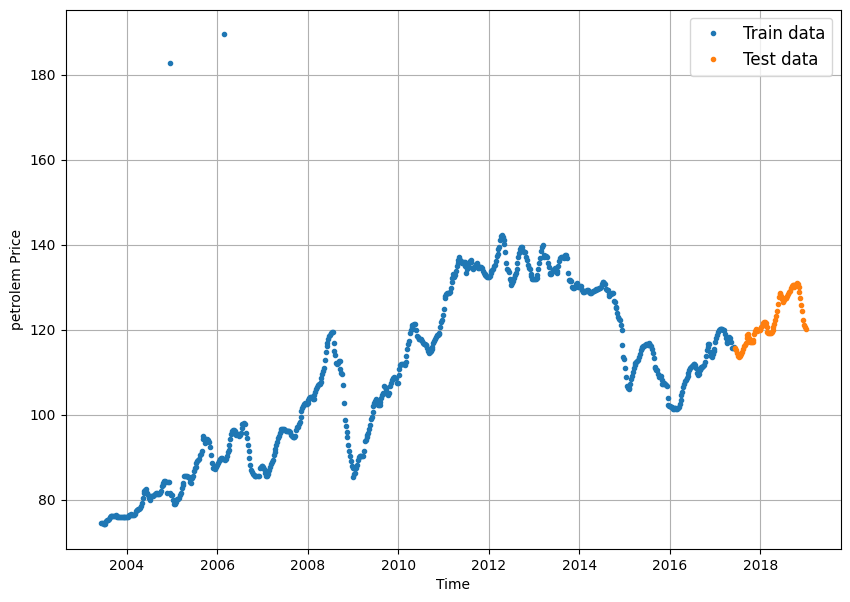

In [ ]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, price=y_train, label="Train data")
plot_time_series(timesteps=X_test, price=y_test, label="Test data")

# **Modelling Experiments**

**Model 0: Naïve forecast (baseline)**

Starting with a baseline.

*   One of the most common baseline models for time series forecasting, the naïve model (also called the naïve forecast), requires no training at all.


*   That's because all the naïve model does is use the previous timestep value to predict the next timestep value.


The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (the previous timestep).

In [ ]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:] # View frist 10 and last 10

(array([115.69, 115.12, 114.43, 113.74, 113.58, 113.89, 113.99, 114.16,
        114.78, 115.53]),
 array([130.98, 130.64, 130.11, 128.94, 127.4 , 125.77, 124.3 , 122.37,
        121.02, 120.61]))

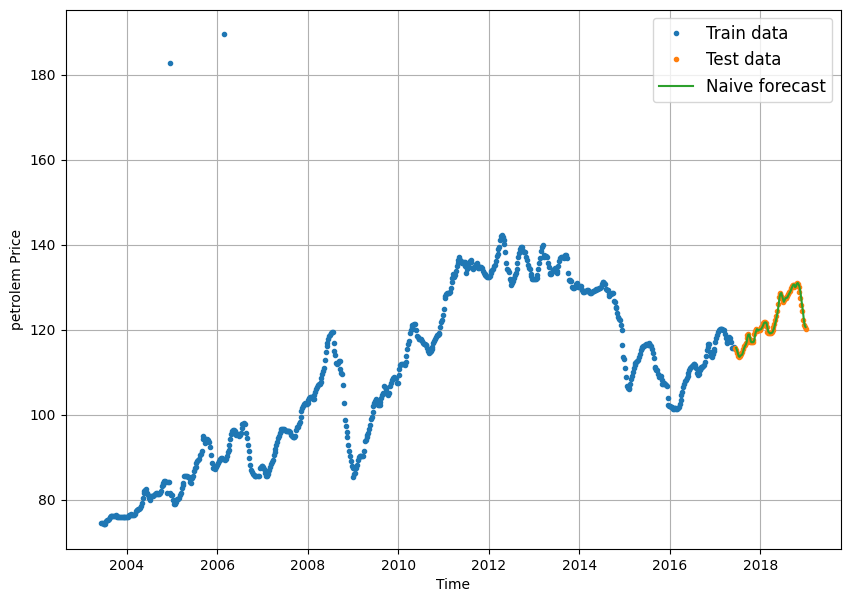

In [ ]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, price=y_train, label="Train data")
plot_time_series(timesteps=X_test, price=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], price=naive_forecast, format="-", label="Naive forecast");

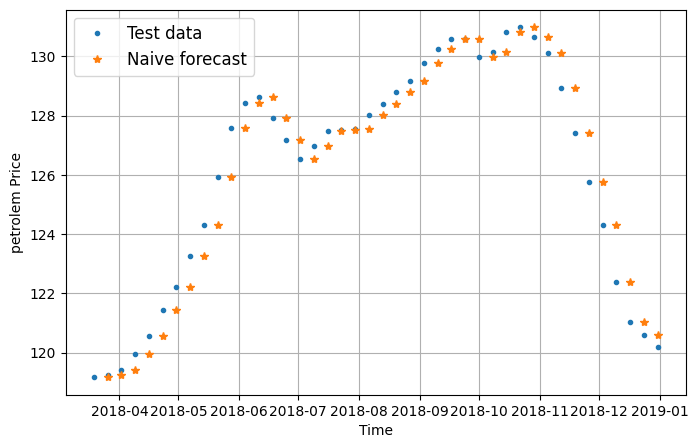

In [ ]:
# zoomming on data plot:
plt.figure(figsize=(8,5))
offset = 40 # offset allows you to focus on a specific portion of your time series data,
plot_time_series(timesteps=X_test, price=y_test, start=offset, label="Test data") # Here offset is 40 as total test len is 82 plot will start from 40 till end
plot_time_series(timesteps=X_test[1:], price=naive_forecast, format="*", start=offset, label="Naive forecast");

In [ ]:
# MASE implemented courtesy of sktime
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season


In [ ]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:

naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 0.56037027,
 'mse': 0.51469517,
 'rmse': 0.7174226,
 'mape': 0.45711222,
 'mase': 1.0002148}

**Part 2: Windowing dataset**

In [ ]:
# create function to label windows data:
def get_labelled_windows(x, horizon=1):
    """
    Creates labels for windowed dataset.
    E.g. if horizon=1 (default)
    Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
    """
    data_1 = x[:,:-horizon] # all rows but not last cloumn
    data_2 = x[:,-horizon:] # all row but column from last
    return data_1, data_2

In [ ]:
## example logic
"""
# Create a 2D NumPy array as an example logic
data = np.array([
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12]
])

subset = data[1:2,-1:]

# Display the original array and the subset
print("Original Array:")
print(data)
print("\nSubset ([:, :-1]):")
print(subset)
"""

'\n# Create a 2D NumPy array as an example logic\ndata = np.array([\n    [1, 2, 3, 4],\n    [5, 6, 7, 8],\n    [9, 10, 11, 12]\n])\n\nsubset = data[1:2,-1:]\n\n# Display the original array and the subset\nprint("Original Array:")\nprint(data)\nprint("\nSubset ([:, :-1]):")\nprint(subset)\n'

In [ ]:
# Test out the window labelling function
EXPANDED_ARRAY = tf.expand_dims(tf.range(8)+1, axis=0)
HORIZON =1
test_window, test_label = get_labelled_windows(EXPANDED_ARRAY,HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]

[1, 2, 3, 4, 5, 6, 7] -> [8]

[2, 3, 4, 5, 6, 7, 8] -> [9]

In [ ]:
# create function to label windows data:
def get_windows(x, horizon, window_size):
    """
    Creates labels for windowed dataset.
    E.g. if horizon=1 (default)
    Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])

    Step:Turns a 1D array into a 2D array of sequential windows of window_size.
    """
    # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
    window_step = np.expand_dims(np.arange(horizon+window_size),axis = 0)
    #print(f"Window step:\n {window_step}{len(window_step)}")

    # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x) -(window_size + horizon-1)), axis=0).T
    #print(f"Window indexes:\n {window_indexes[:2], window_indexes[-2:], window_indexes.shape}")

    # 3. Index on the target array (time series) with 2D array of multiple window steps
    windowed_array = x[window_indexes]
    windows, labels = windowed_array[:, :-horizon], windowed_array[:, -horizon:]
    return windows, labels


In [ ]:
# testing code: skip it
np.expand_dims(np.arange(len(prices) -(7 + 1-1)),axis=0).T+[[1,2]]

array([[  1,   2],
       [  2,   3],
       [  3,   4],
       ...,
       [802, 803],
       [803, 804],
       [804, 805]])

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7
print(f"sample window size: {get_windows(prices[:8],HORIZON,WINDOW_SIZE)}")
full_windows, full_labels = get_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)


sample window size: (array([[74.59, 74.47, 74.42, 74.35, 74.28, 74.21, 75.07]]), array([[75.1]]))


(804, 804)

In [ ]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [74.59 74.47 74.42 74.35 74.28 74.21 75.07] -> Label: [75.1]
Window: [74.47 74.42 74.35 74.28 74.21 75.07 75.1 ] -> Label: [75.12]
Window: [74.42 74.35 74.28 74.21 75.07 75.1  75.12] -> Label: [75.44]


In [ ]:
# View the last 3 windows/labels
for i in range(3):
    print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [130.64 130.11 128.94 127.4  125.77 124.3  122.37] -> Label: [121.02]
Window: [130.11 128.94 127.4  125.77 124.3  122.37 121.02] -> Label: [120.61]
Window: [128.94 127.4  125.77 124.3  122.37 121.02 120.61] -> Label: [120.18]


In [ ]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split):
    """
    Splits matching pairs of windows and labels into train and test splits.
    """
    split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [ ]:
int(len(full_windows))

804

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels,0.10)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(723, 81, 723, 81)

In [ ]:
## checking splits
train_windows[:5], train_labels[:5]

(array([[74.59, 74.47, 74.42, 74.35, 74.28, 74.21, 75.07],
        [74.47, 74.42, 74.35, 74.28, 74.21, 75.07, 75.1 ],
        [74.42, 74.35, 74.28, 74.21, 75.07, 75.1 , 75.12],
        [74.35, 74.28, 74.21, 75.07, 75.1 , 75.12, 75.44],
        [74.28, 74.21, 75.07, 75.1 , 75.12, 75.44, 75.81]]),
 array([[75.1 ],
        [75.12],
        [75.44],
        [75.81],
        [76.05]]))

**Model 1: Dense model (window = 7, horizon = 1)**

Model_1 will have:

- A single dense layer with 128 hidden units and ReLU (rectified linear unit) activation
- An output layer with linear activation (or no activation)
- Adam optimizer and MAE loss function
- Batch size of 128
- 100 epochs


In [ ]:
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE



In [ ]:
# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels))


Epoch 1/100
6/6 [==============================] - 5s 39ms/step - loss: 115.1169 - mae: 115.1169 - val_loss: 103.0360 - val_mae: 103.0360
Epoch 2/100
6/6 [==============================] - 0s 8ms/step - loss: 77.0068 - mae: 77.0068 - val_loss: 59.8864 - val_mae: 59.8864
Epoch 3/100
6/6 [==============================] - 0s 8ms/step - loss: 38.2089 - mae: 38.2089 - val_loss: 15.4433 - val_mae: 15.4433
Epoch 4/100
6/6 [==============================] - 0s 7ms/step - loss: 8.9336 - mae: 8.9336 - val_loss: 17.1032 - val_mae: 17.1032
Epoch 5/100
6/6 [==============================] - 0s 8ms/step - loss: 15.7503 - mae: 15.7503 - val_loss: 10.9696 - val_mae: 10.9696
Epoch 6/100
6/6 [==============================] - 0s 8ms/step - loss: 5.8451 - mae: 5.8451 - val_loss: 7.6107 - val_mae: 7.6107
Epoch 7/100
6/6 [==============================] - 0s 7ms/step - loss: 6.8233 - mae: 6.8233 - val_loss: 2.5333 - val_mae: 2.5333
Epoch 8/100
6/6 [==============================] - 0s 8ms/step - loss: 3.8

In [ ]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)


3/3 [==============================] - 0s 5ms/step - loss: 1.0556 - mae: 1.0556


[1.0555899143218994, 1.0555899143218994]

In [ ]:
# forcasting on test Dataset:

def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [ ]:
test_windows[:3]

array([[118.08, 117.06, 115.6 , 115.67, 115.79, 115.82, 115.69],
       [117.06, 115.6 , 115.67, 115.79, 115.82, 115.69, 115.12],
       [115.6 , 115.67, 115.79, 115.82, 115.69, 115.12, 114.43]])

In [ ]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

3/3 [==============================] - 0s 4ms/step


(81,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([116.698906, 116.378784, 115.77398 , 115.173256, 114.7663  ,
        114.74549 , 114.78768 , 114.921074, 115.342545, 115.867325],
       dtype=float32)>)

In [ ]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 1.0555899,
 'mse': 2.008734,
 'rmse': 1.4172981,
 'mape': 0.86521125,
 'mase': 1.8841411}

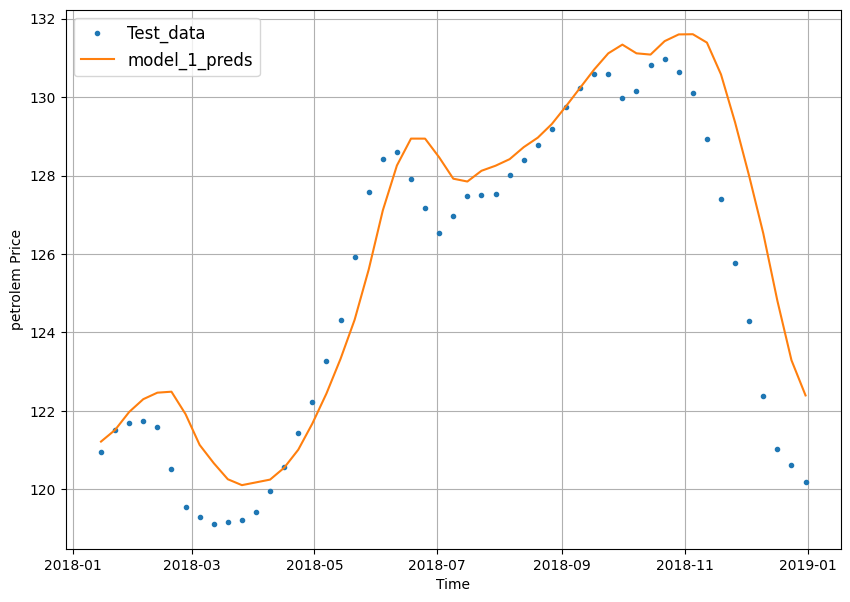

In [ ]:
offset = 30
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], price=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], price=model_1_preds, start=offset, format="-", label="model_1_preds")


**Trying making windows size = 30**

In [ ]:
HORIZON = 1
WINDOW_SIZE = 30
print(f"sample window size: {get_windows(prices[:8],HORIZON,WINDOW_SIZE)}")
full_windows, full_labels = get_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)


sample window size: (array([], shape=(0, 30), dtype=float64), array([], shape=(0, 1), dtype=float64))


(781, 781)

In [ ]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split = 0.1)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(702, 79, 702, 79)

In [ ]:
# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels))

In [ ]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

3/3 [==============================] - 0s 6ms/step - loss: 2.5087


2.5086593627929688

**Model_4**

Conv1D

Conv1D models can be used for seq2seq (sequence to sequence) problems.

In our case, the input sequence is the previous 7 days of price data and the output is the next day (in seq2seq terms this is called a many to one problem).

In [ ]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [ ]:
# Create windowed dataset
full_windows, full_labels = get_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(804, 804)

In [ ]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels, test_split=0.1)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(723, 81, 723, 81)

**The Conv1D layer in TensorFlow takes an input of: (batch_size, timesteps, input_dim).**

- timesteps = WINDOW_SIZE - the timesteps is also often referred to as features, our features are the previous WINDOW_SIZE values of price

- input_dim = HORIZON - our model views WINDOW_SIZE (one week) worth of data at a time to predict HORIZON (one day)

Right now, our data has the timesteps dimension ready but we'll have to adjust it to have the input_dim dimension.

In [ ]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

In [ ]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works(testing - skip it)
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=array([74.59, 74.47, 74.42, 74.35, 74.28, 74.21, 75.07])>

In [ ]:
## testing - skip it
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim)
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[74.59]
 [74.47]
 [74.42]
 [74.35]
 [74.28]
 [74.21]
 [75.07]]


In [ ]:
# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

In [ ]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])


model_4.summary()

In [ ]:
# Load in best performing Conv1D model and evaluate it on the test data
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)


# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

In [ ]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results


Model 5: RNN (LSTM)

one of the most important steps for the LSTM model will be getting our data into the right shape.

The tf.keras.layers.LSTM() layer takes a tensor with [batch, timesteps, feature] dimensions.

As mentioned earlier, the batch dimension gets taken care of for us but our data is currently only has the feature dimension (WINDOW_SIZE).

To fix this, just like we did with the Conv1D model, we can use a tf.keras.layers.Lambda() layer to adjust the shape of our input tensors to the LSTM layer.

In [ ]:
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu", return_sequences=True)(x)
x = layers.LSTM(128, activation = "relu",return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

In [ ]:
# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_5.summary()

In [ ]:
# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [ ]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)


In [ ]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

In [ ]:
# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

**Making a windowed dataset with pandas**

- Since our data is in a pandas DataFrame, we can leverage the pandas.

- DataFrame.shift() method to create a windowed multivariate time series.

- The shift() method offsets an index by a specified number of periods.

# Building and testing an N-BEATS block layer

N-BEATS (Neural Basis Expansion Analysis for Interpretable Time Series Forecasting).

In [ ]:
# N-beat custom layer: Replicating nbeats paper
class NBeatsBlock(tf.keras.layers.Layer):
    def __init__(self,
                input_size: int,
                theta_size: int,
                horizon: int,
                n_neurons: int,
                n_layers: int,
                **kwargs):
        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers
        self.hidden = []

        # Block contains stack of 4 fully connected layers each has ReLU activation
        for _ in range(n_neurons):
            layer = tf.keras.layers.Dense(n_neurons, activation="relu")
            self.hidden.append(layer)

        # Output of block is a theta layer with linear activation
        self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

    def call(self, inputs): # the call method is what runs when the layer is called
        x = inputs
        for layer in self.hidden: # pass inputs through each hidden layer
            x = layer(x)
        theta = self.theta_layer(x)

        # Output the backcast and forecast from theta
        backcast = theta[:, :self.input_size]
        forecast = theta[:, -self.horizon:]
        return backcast, forecast

Setting up the NBeatsBlock custom layer we observed:

- The class inherits from tf.keras.layers.Layer (this gives it all of the methods assosciated with tf.keras.layers.Layer)


- The constructor (def __init__(...)) takes all of the layer hyperparameters as well as the **kwargs argument


- The **kwargs argument takes care of all of the hyperparameters which aren't mentioned in the constructor such as, input_shape, trainable and name

**In the constructor, the block architecture layers are created:**

- The hidden layers are created as a stack of fully connected with n_nuerons hidden units layers with ReLU activation.

- The theta layer uses theta_size hidden units as well as linear activation
The call() method is what is run when the layer is called:

- It first passes the inputs (the historical Bitcoin data) through each of the hidden layers (a stack of fully connected layers with ReLU activation)

- After the inputs have been through each of the fully connected layers, they get passed through the theta layer where the backcast (backwards predictions,
- shape: input_size) and forecast (forward predictions, shape: horizon) are returned

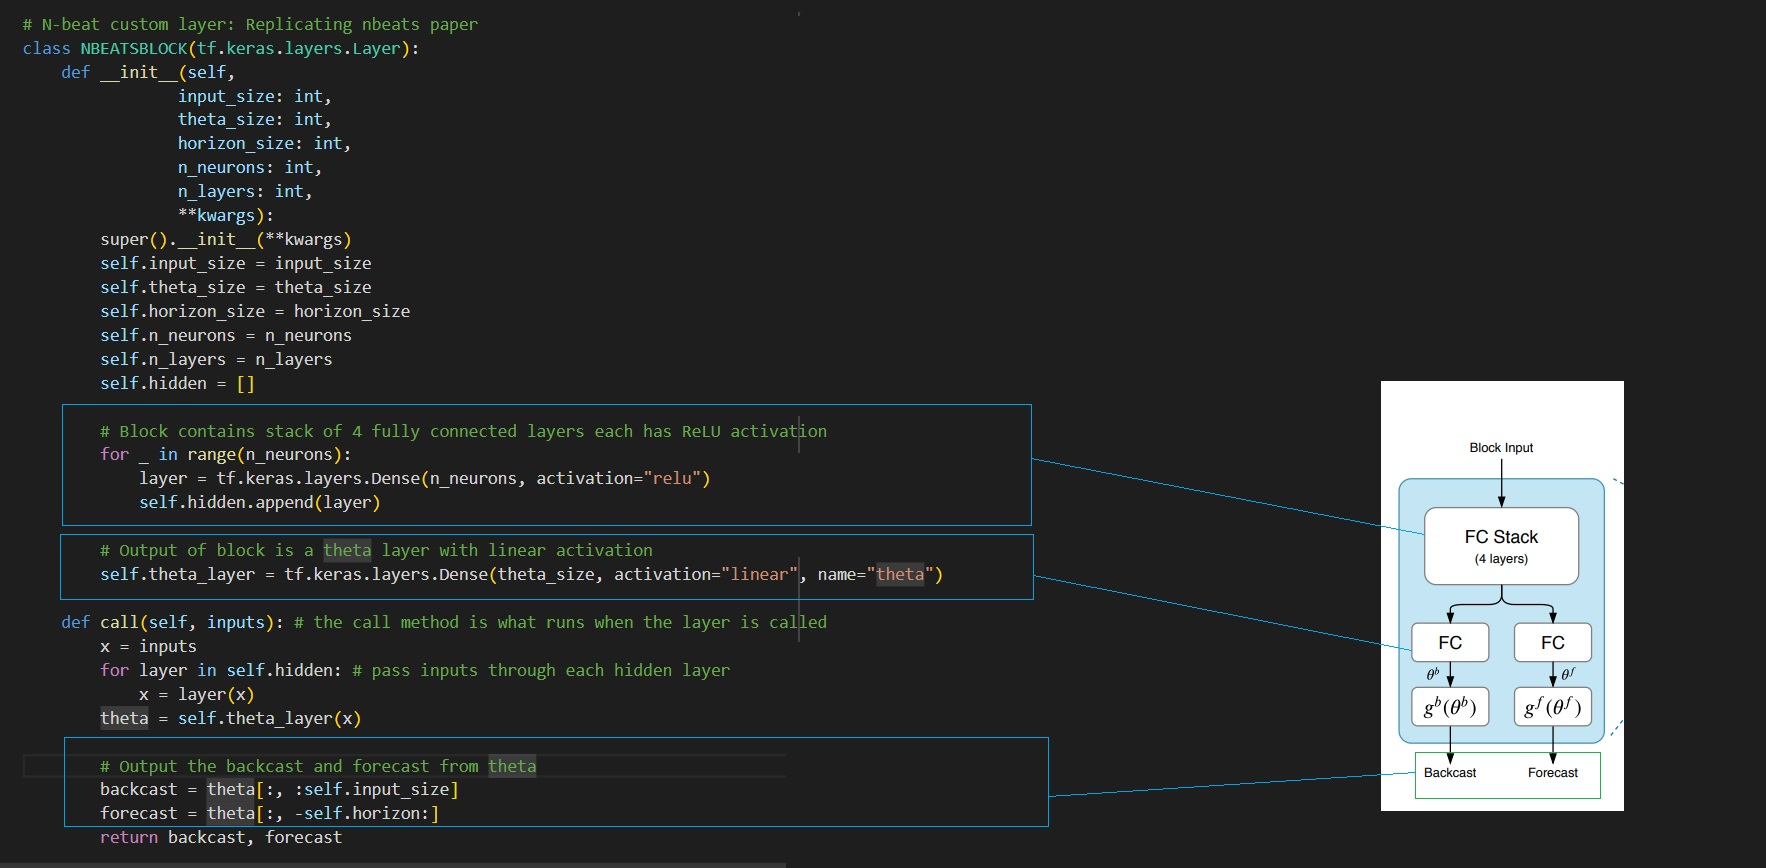

In [ ]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

In [ ]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=32,
                                       n_layers=4)



# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

Preparing data for the N-BEATS algorithm using tf.data

In [ ]:
petrol_prices_nbeats = data.copy()
petrol_prices_nbeats

,price
Date,
2003-06-09,74.59
2003-06-16,74.47
2003-06-23,74.42
2003-06-30,74.35
2003-07-07,74.28
...,...
2018-12-03,124.30
2018-12-10,122.37
2018-12-17,121.02


In [ ]:
# Add windowed columns
for i in range(WINDOW_SIZE):
  petrol_prices_nbeats[f"price{i+1}"] = petrol_prices_nbeats["price"].shift(periods=i+1)

# sample:
petrol_prices_nbeats.head(10)

,price,price1,price2,price3,price4,price5,price6,price7
Date,,,,,,,,
2003-06-09,74.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-06-16,74.47,74.59,NaN,NaN,NaN,NaN,NaN,NaN
2003-06-23,74.42,74.47,74.59,NaN,NaN,NaN,NaN,NaN
2003-06-30,74.35,74.42,74.47,74.59,NaN,NaN,NaN,NaN
2003-07-07,74.28,74.35,74.42,74.47,74.59,NaN,NaN,NaN
2003-07-14,74.21,74.28,74.35,74.42,74.47,74.59,NaN,NaN
2003-07-21,75.07,74.21,74.28,74.35,74.42,74.47,74.59,NaN
2003-07-28,75.10,75.07,74.21,74.28,74.35,74.42,74.47,74.59
2003-08-04,75.12,75.10,75.07,74.21,74.28,74.35,74.42,74.47


In [ ]:
# Make features and labels
X = petrol_prices_nbeats.dropna().drop("price", axis=1)
y = petrol_prices_nbeats.dropna()["price"]

# Make train and test sets
split_size = int(len(X) * 0.9)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(723, 723, 81, 81)

In [ ]:
X_train.head(3)

,price1,price2,price3,price4,price5,price6,price7
Date,,,,,,,
2003-07-28,75.07,74.21,74.28,74.35,74.42,74.47,74.59
2003-08-04,75.10,75.07,74.21,74.28,74.35,74.42,74.47
2003-08-11,75.12,75.10,75.07,74.21,74.28,74.35,74.42


1. Turning the arrays in tensor Datasets using tf.data.Dataset.from_tensor_slices()

- Note: from_tensor_slices() works best when your data fits in memory, for extremely large datasets, you'll want to look into using the TFRecord format

2. Combine the labels and features tensors into a Dataset using tf.data.Dataset.zip()

3. Batch and prefetch the Datasets using batch() and prefetch()

- **Batching and prefetching ensures the loading time from CPU (preparing data) to GPU (computing on data) is as small as possible**

In [ ]:
# 1. Turning the arrays in tensor Datasets using tf.data.Dataset.from_tensor_slices()
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))


# 3. Batch and prefetch for optimal performance
#BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper

BATCH_SIZE = 32
BUFFER_SIZE = 1000
#train_dataset = train_dataset.batch(BATCH_SIZE).shuffle(buffer_size = BUFFER_SIZE).prefetch(tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset  = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset,test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

Setting up hyperparameters for N-BEATS algorithm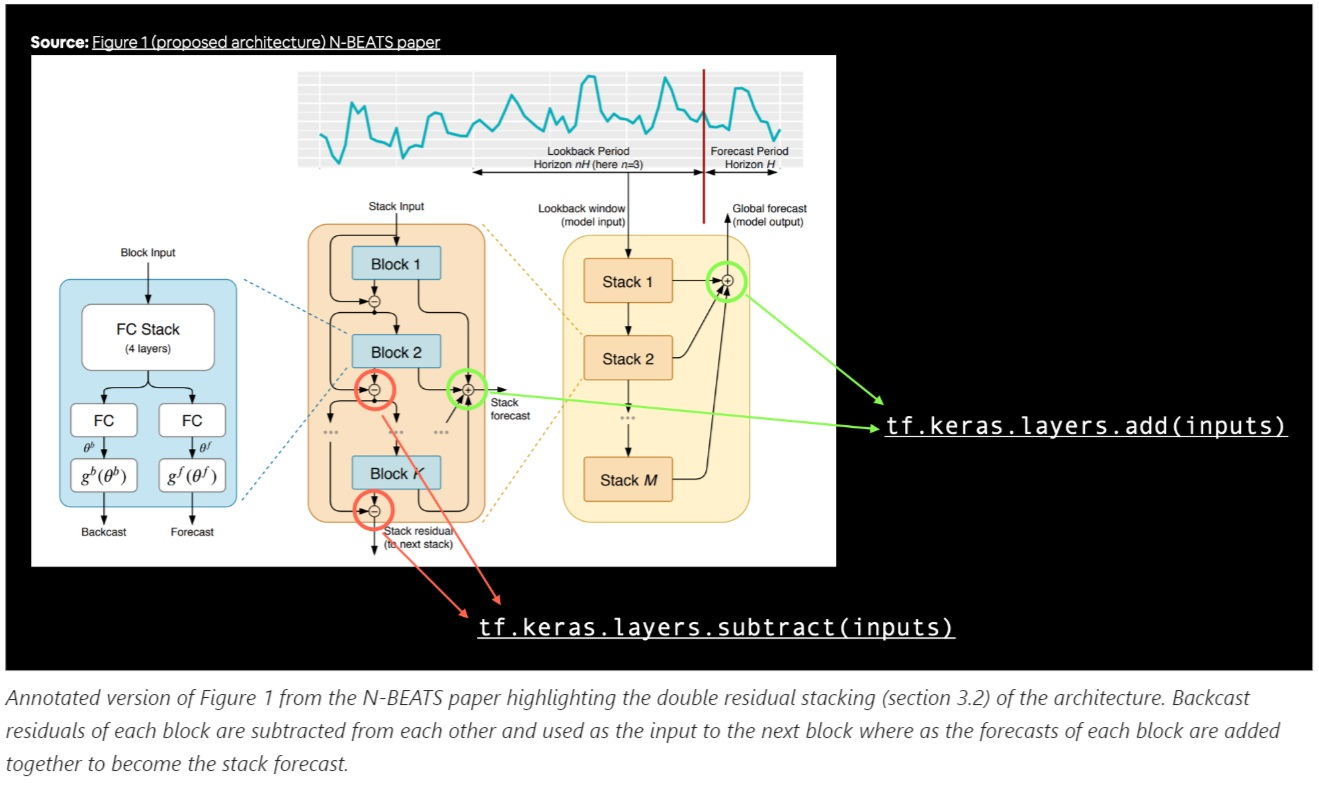

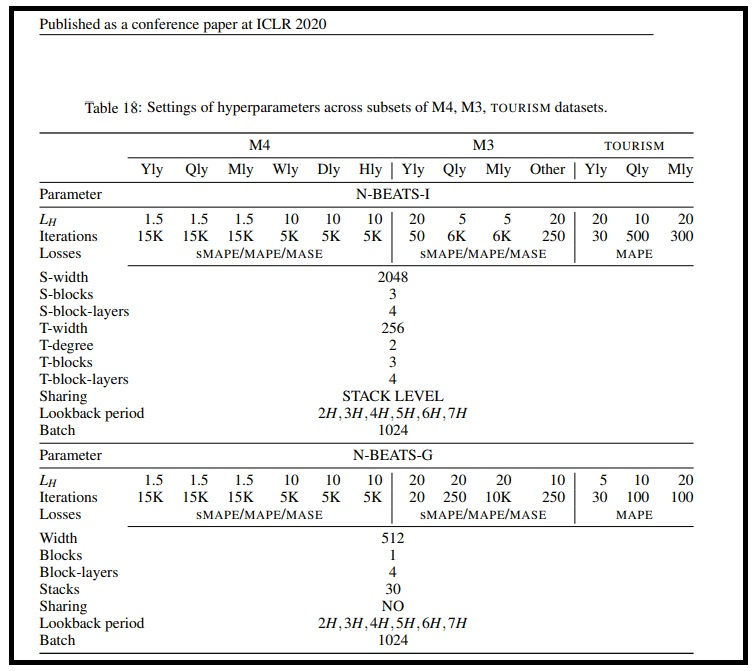

In [ ]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

**Getting ready for residual connections**

- Before we create the N-BEATS model, there are two layers to go through which play a large roll in the architecture.

- They're what make N-BEATS double residual stacking (section 3.2 of the N-BEATS paper):

**tf.keras.layers.subtract(inputs)** - subtracts list of input tensors from each other

**tf.keras.layers.add(inputs)** - adds list of input tensors to each other
Let's try them out.

In [ ]:
# Make tensors
from tensorflow.keras import layers

tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


- A residual connection (also called skip connections) involves a deeper neural network layer receiving the outputs as well as the inputs of a shallower neural network layer.

- **In the case of N-BEATS, the architecture uses residual connections which:**

- Subtract the backcast outputs from a previous block from the backcast inputs to the current block.

- Add the forecast outputs from all blocks together in a stack

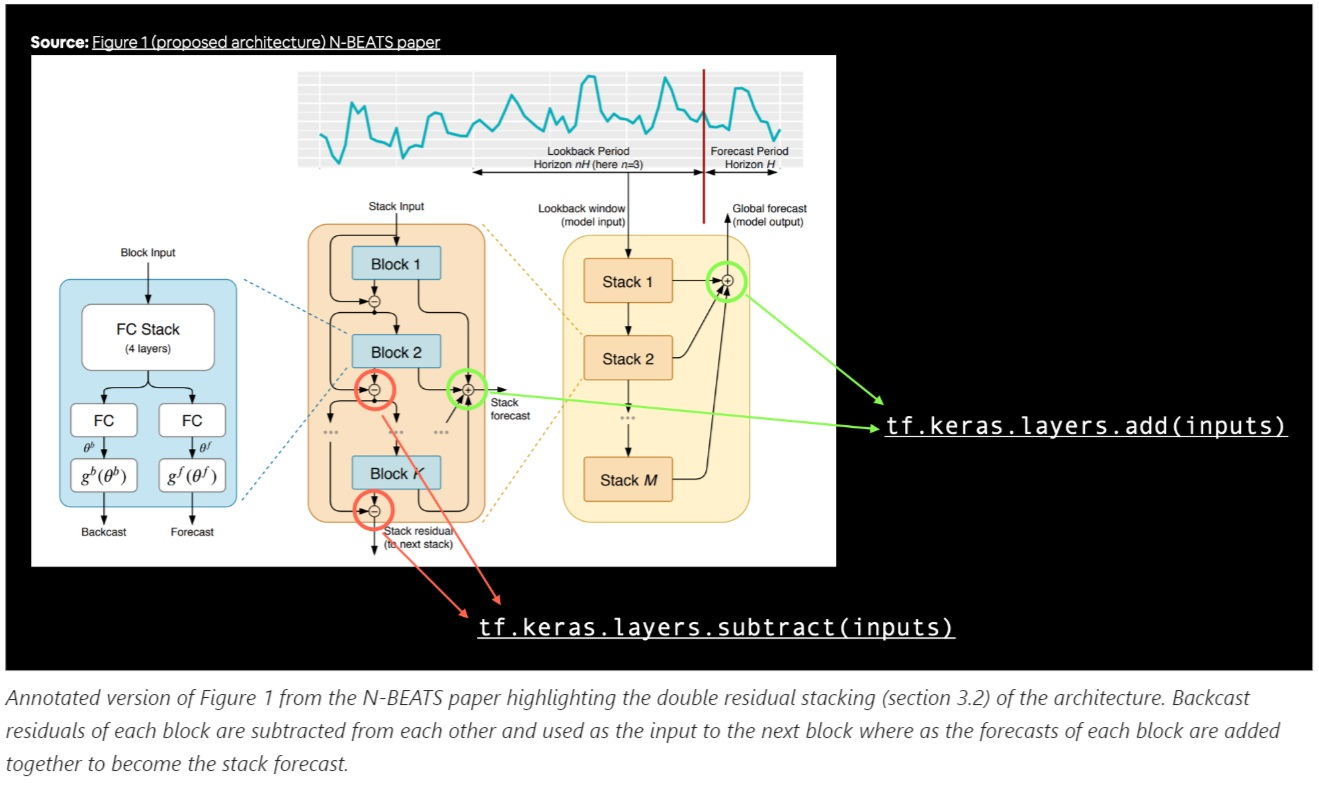



What are the benefits of residual connections?

In practice, residual connections have been beneficial for training deeper models (N-BEATS reaches ~150 layers, also see "These approaches provide clear advantages in improving the trainability of deep architectures" in [section 3.2 ](https://arxiv.org/pdf/1905.10437.pdf) of the N-BEATS paper).

# **Building, compiling and fitting the N-BEATS algorithm**

We've finally got all of the pieces of the puzzle ready for building and training the N-BEATS algorithm.

We'll do so by going through the following:

1. Setup an instance of the N-BEATS block layer using NBeatsBlock (this'll be the initial block used for the network, the rest will be created as part of stacks)

2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API for this)

3. Make the initial backcast and forecasts for the model with the layer created in (1)

4. Use a for loop to create stacks of block layers

5. Use the NBeatsBlock class within the for loop created in (4) to create blocks which return backcasts and block-level forecasts.

6. Create the double residual stacking using subtract and add layers
Put the model inputs and outputs together using **tf.keras.Model()**

7. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default settings as per section 5.2 of N-BEATS paper)

8. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:

    - **tf.keras.callbacks.EarlyStopping() **- stop the model from training if it doesn't improve validation loss for 200 epochs and restore the best performing weights using restore_best_weights=True

    - **tf.keras.callbacks.ReduceLROnPlateau()**- if the model's validation loss doesn't improve for 100 epochs, reduce the learning rate by 10x to try and help it make incremental improvements (the smaller the learning rate, the smaller updates a model tries to make)

In [ ]:
%%time
# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)

# Add in subtraction residual link
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=3, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=50, verbose=1)])

Epoch 1/200


In [ ]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)


# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]


# Evaluate N-BEATS model predictions
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results


In [ ]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)


Constructing and fitting an ensemble of models (using different loss functions)


In [ ]:

def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=100,
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later:
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])

      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])

      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models


In [ ]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)